### Supervised Learning - k-Nearest Neighbors

*Nikola Savic at gmail dot com*

## Imports

In [53]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier

## Fetch, Split and Standardize Data

In [26]:
random_state = 2020
np.random.seed(random_state)

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)


X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}

mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}

## Shared Functions

In [27]:
def print_cross_val(clf, data_set, cv=5, v=1):
    print(clf)    
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=-1)
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

In [28]:
def build_confusion_matrix(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize="true", cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [29]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [67]:
def build_cred_precision_recall_curve(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)
    
    clf.fit(X_train, y_train)
    y_score = clf.predict(X_test)

    disp = plot_precision_recall_curve(clf, X_test, y_test)
    disp.ax_.set_title('{0} Precision-Recall curve'.format(name))

In [105]:
def build_validation_curve(clf, data_set, param_name, param_range, scoring="accuracy", cv=5):
    print(clf)
    X, y, name = get_data(data_set)
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv, n_jobs=-1
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    train_scores_max = np.max(train_scores_mean)
    train_scores_max_idx = np.argmax(train_scores_mean)
    train_scores_max_x = param_range[train_scores_max_idx]
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    test_scores_max = np.max(test_scores_mean)
    test_scores_max_idx = np.argmax(test_scores_mean)
    test_scores_max_x = param_range[test_scores_max_idx]

    plt.title("Validation Curve with " + clf.__class__.__name__ + " : " + name)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    plt.ylim(0.0, 1.1)
    lw = 2
    
    plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw,
              marker="x",markeredgewidth=3, ms=8, markevery=[train_scores_max_idx])

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="darkorange", lw=lw)

    plt.plot(param_range, test_scores_mean, label="Test score", color="navy", lw=lw,
             marker="x", markeredgewidth=3, ms=8, markevery=[test_scores_max_idx])

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="navy", lw=lw)
    
    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.axvline(x=train_scores_max_x, linestyle="--", color="darkorange")
    plt.annotate("Train %0.2f" % train_scores_max, (train_scores_max_x, train_scores_max + 0.05))
   
    plt.axvline(x=test_scores_max_x, linestyle="--", color="navy")
    plt.annotate("Test %0.2f" % test_scores_max, (test_scores_max_x, test_scores_max - 0.05))

    plt.legend(loc="best")
    plt.show()

In [32]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    print(clf)
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(DecisionTreeClassifier(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

## Training: cross_val scores (accuracy)

In [71]:
n_neighbors = 9
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
print_cross_val(cknn, cred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


KNeighborsClassifier : Credit Train
Scores:  [0.7875  0.75    0.75625 0.79375 0.74375] Avg:  0.7662500000000001


In [65]:
n_neighbors = 11
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
print_cross_val(cknn, cred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


KNeighborsClassifier : Credit Train
Scores:  [0.7875  0.75625 0.775   0.7875  0.71875] Avg:  0.765


In [72]:
print_cross_val(mknn, mnist)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.4s finished


KNeighborsClassifier : MNIST Train
Scores:  [0.97053571 0.97       0.97053571 0.97080357 0.96803571] Avg:  0.9699821428571429


In [38]:
print_cross_val(mknn, mnist)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.9s finished


KNeighborsClassifier : MNIST Train
Scores:  [0.97035714 0.97089286 0.97098214 0.97098214 0.96830357] Avg:  0.9703035714285715


## Learning Curves

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')


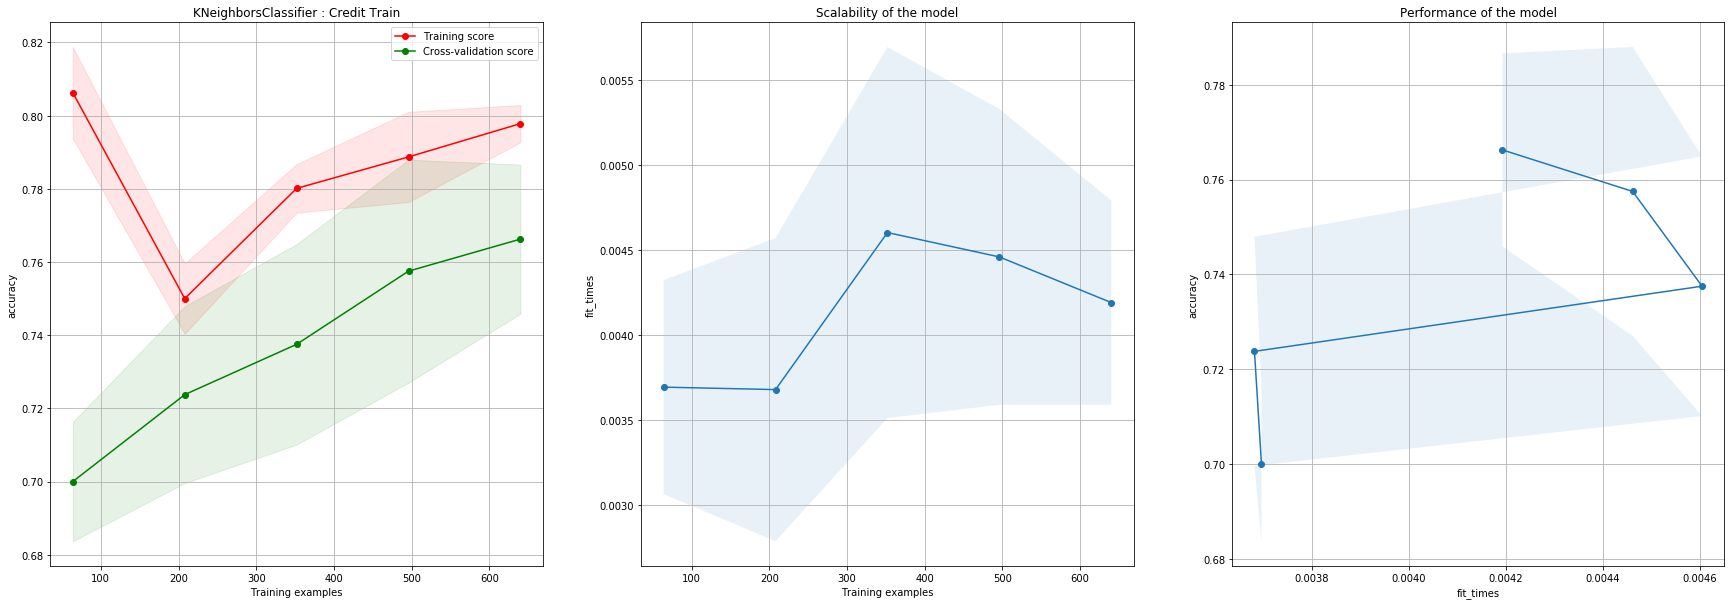

In [74]:
n_neighbors = 9
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(cknn, cred)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')


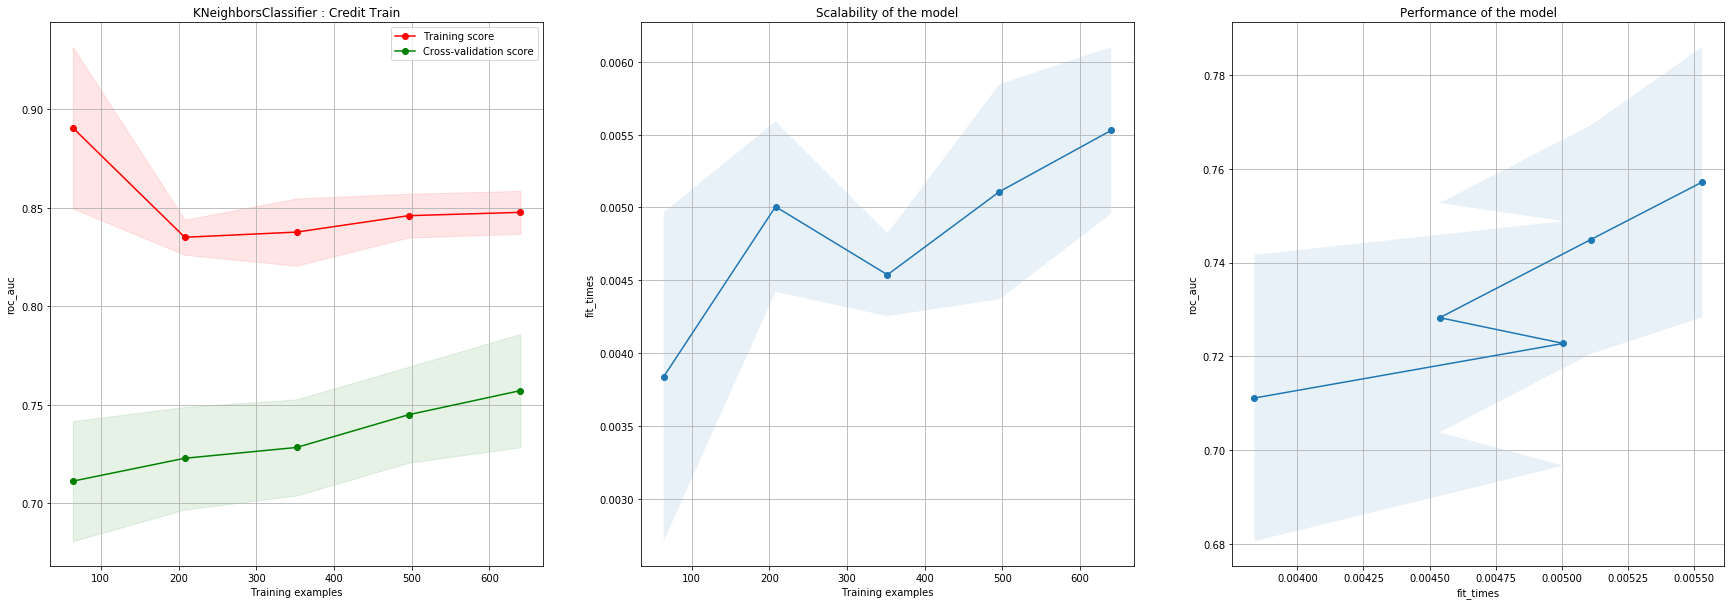

In [75]:
n_neighbors = 9
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(cknn, cred, scoring="roc_auc")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')


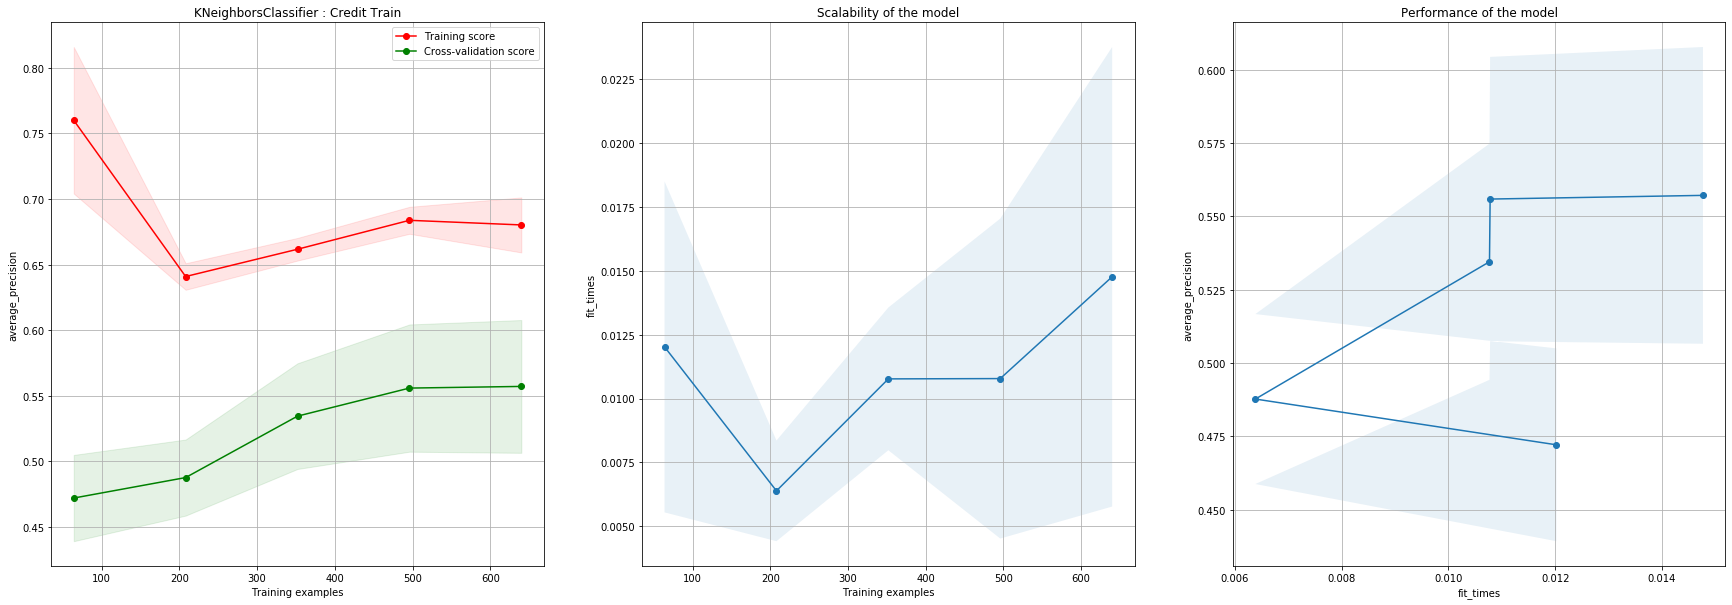

In [54]:
n_neighbors = 9
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(cknn, cred, scoring="average_precision")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='uniform')


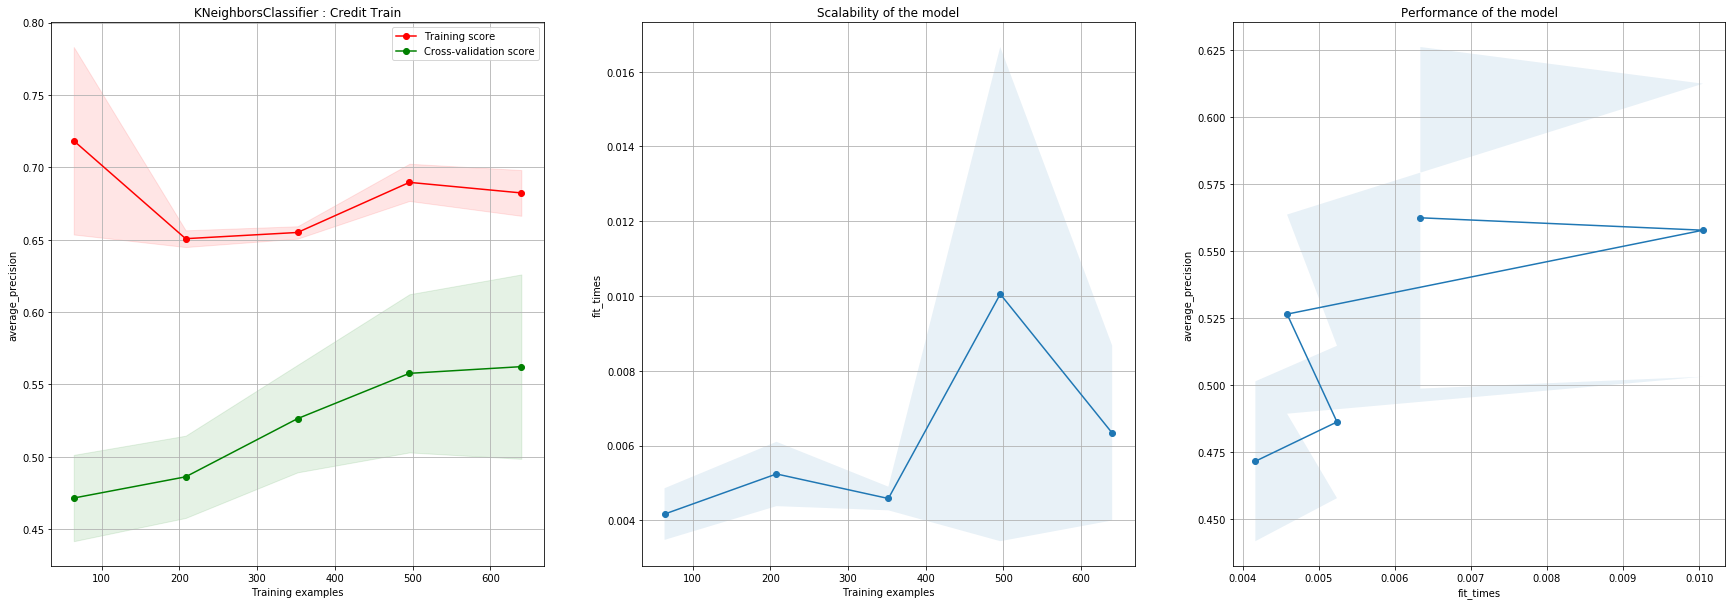

In [55]:
n_neighbors = 10
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(cknn, cred, scoring="average_precision")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                     weights='uniform')


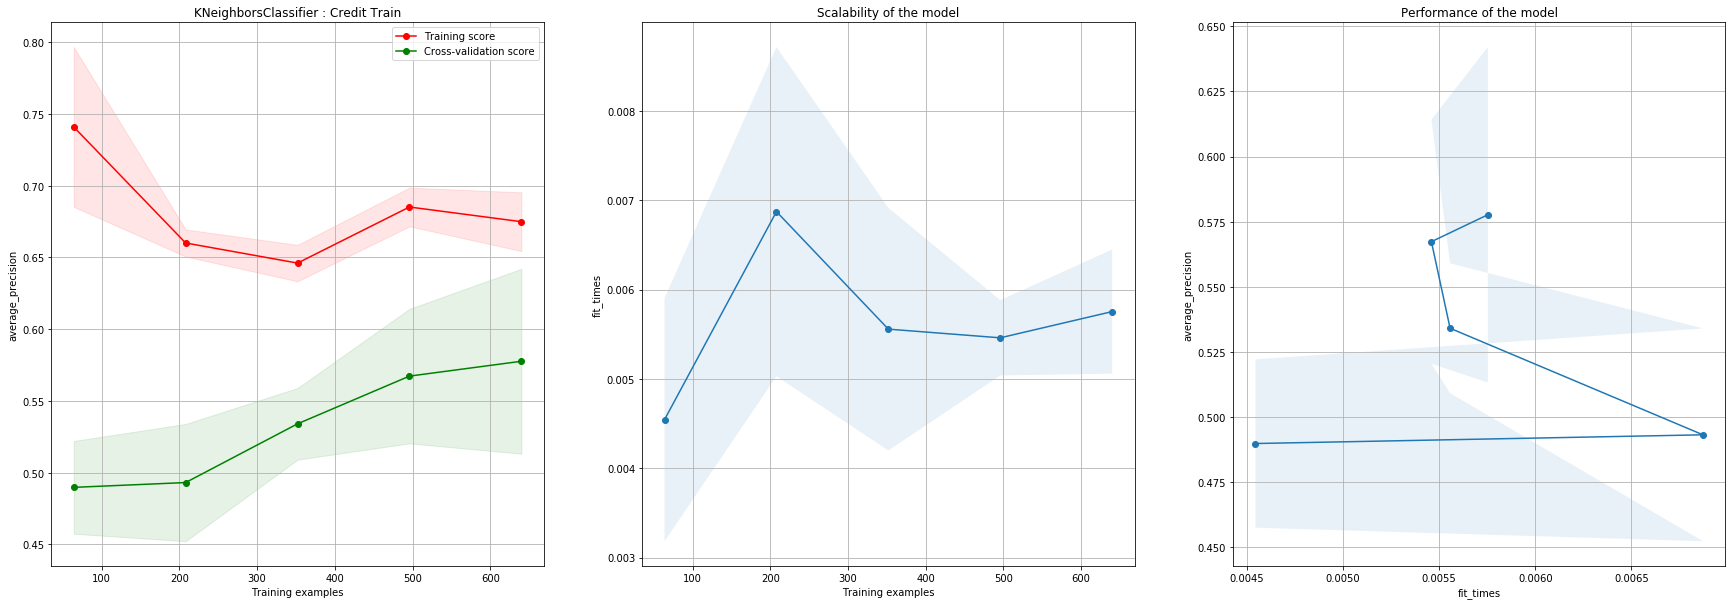

In [56]:
n_neighbors = 11
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(cknn, cred, scoring="average_precision")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
                     weights='uniform')


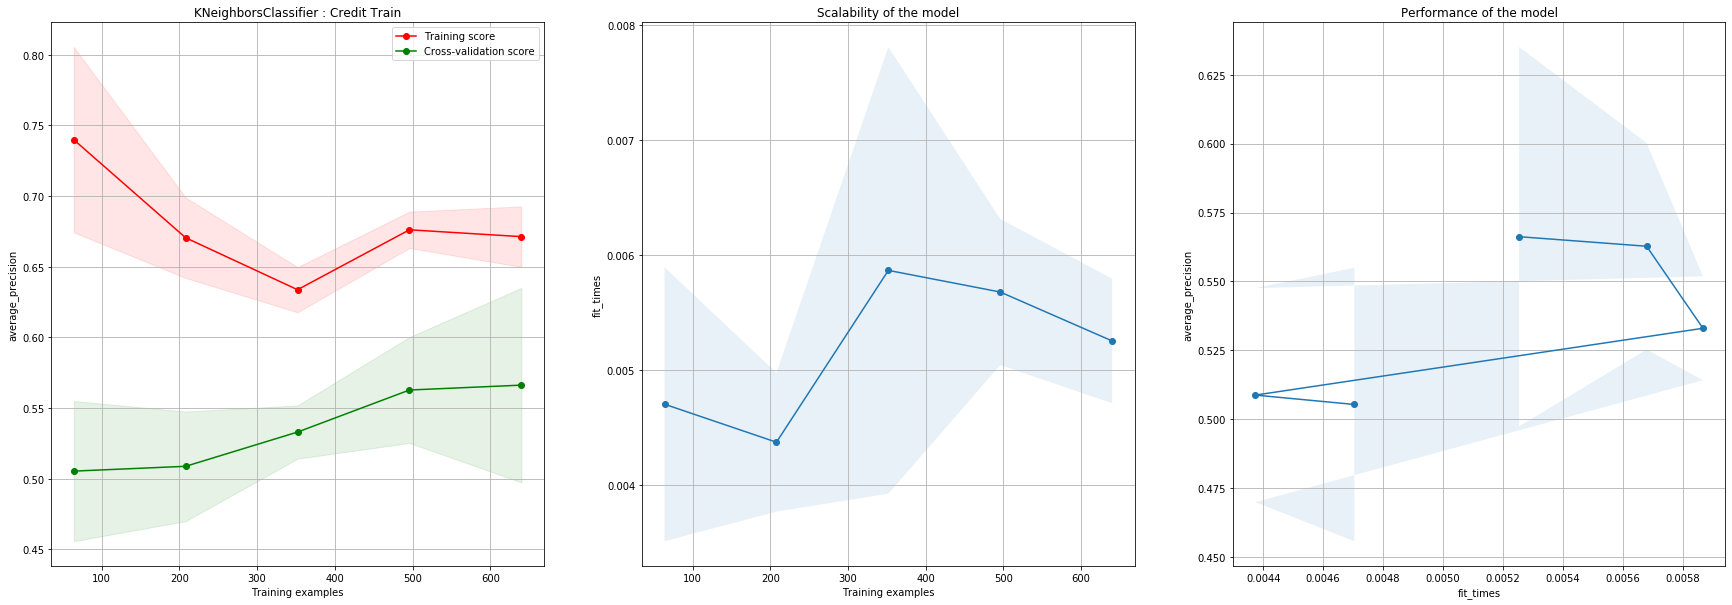

In [58]:
n_neighbors = 12
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(cknn, cred, scoring="average_precision")

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
                     weights='uniform')


/home/nikola/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


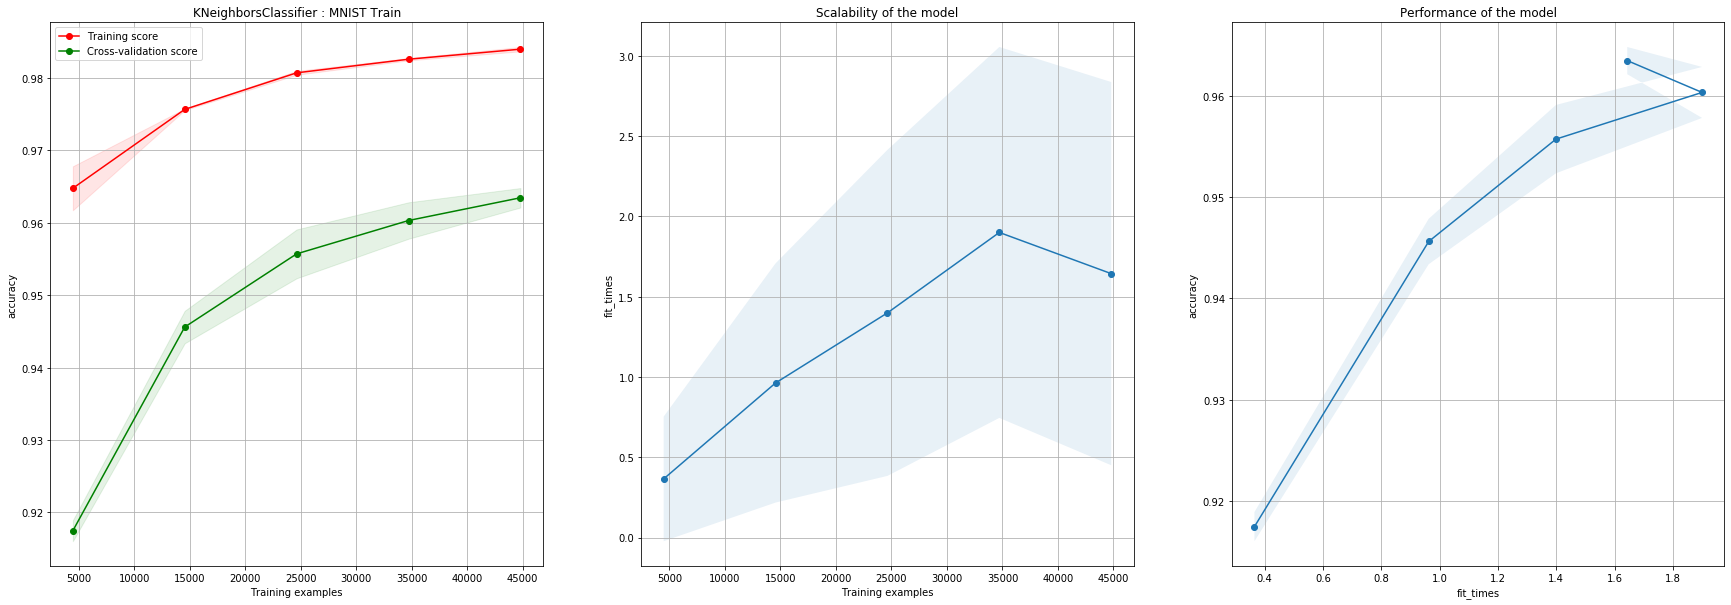

In [50]:
n_neighbors = 2
n_jobs = -1
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(mknn, mnist)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')


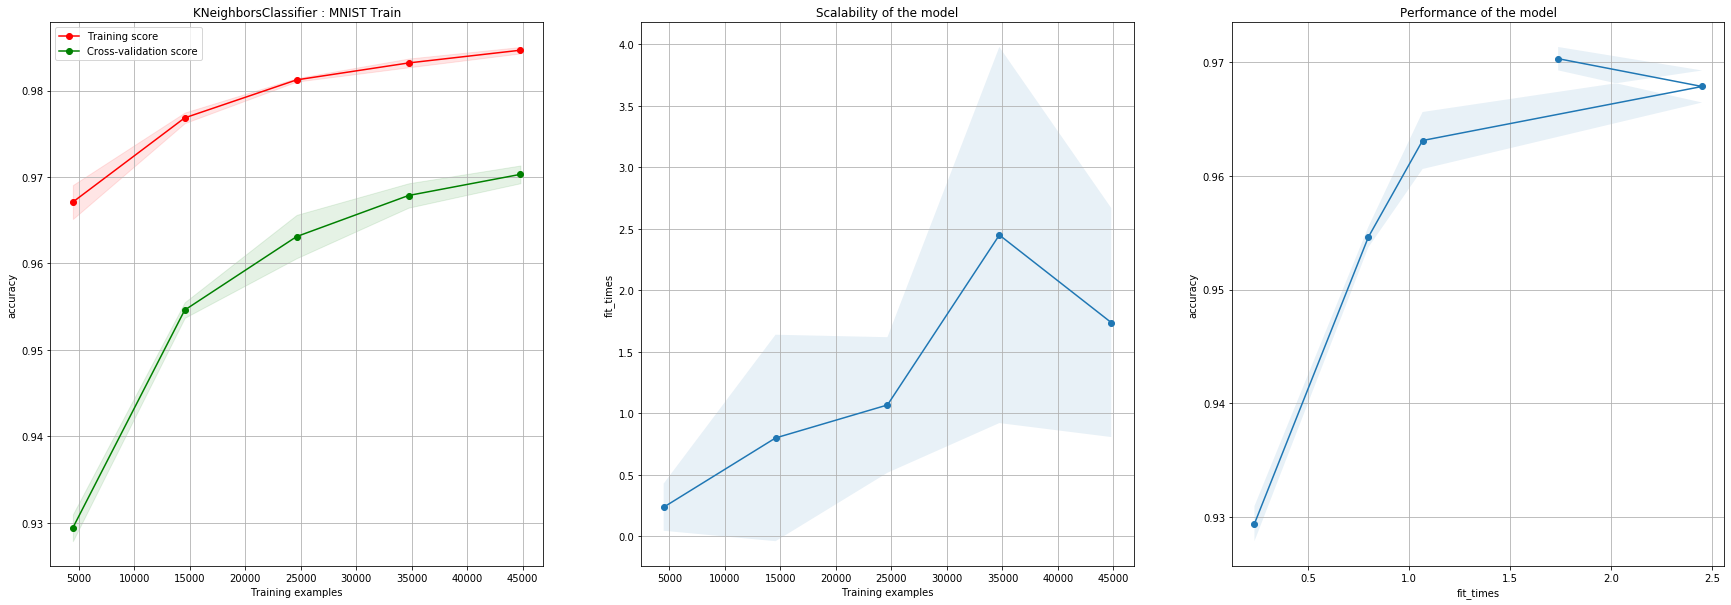

In [17]:
n_neighbors = 3
n_jobs = -1
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(mknn, mnist)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='uniform')


/home/nikola/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


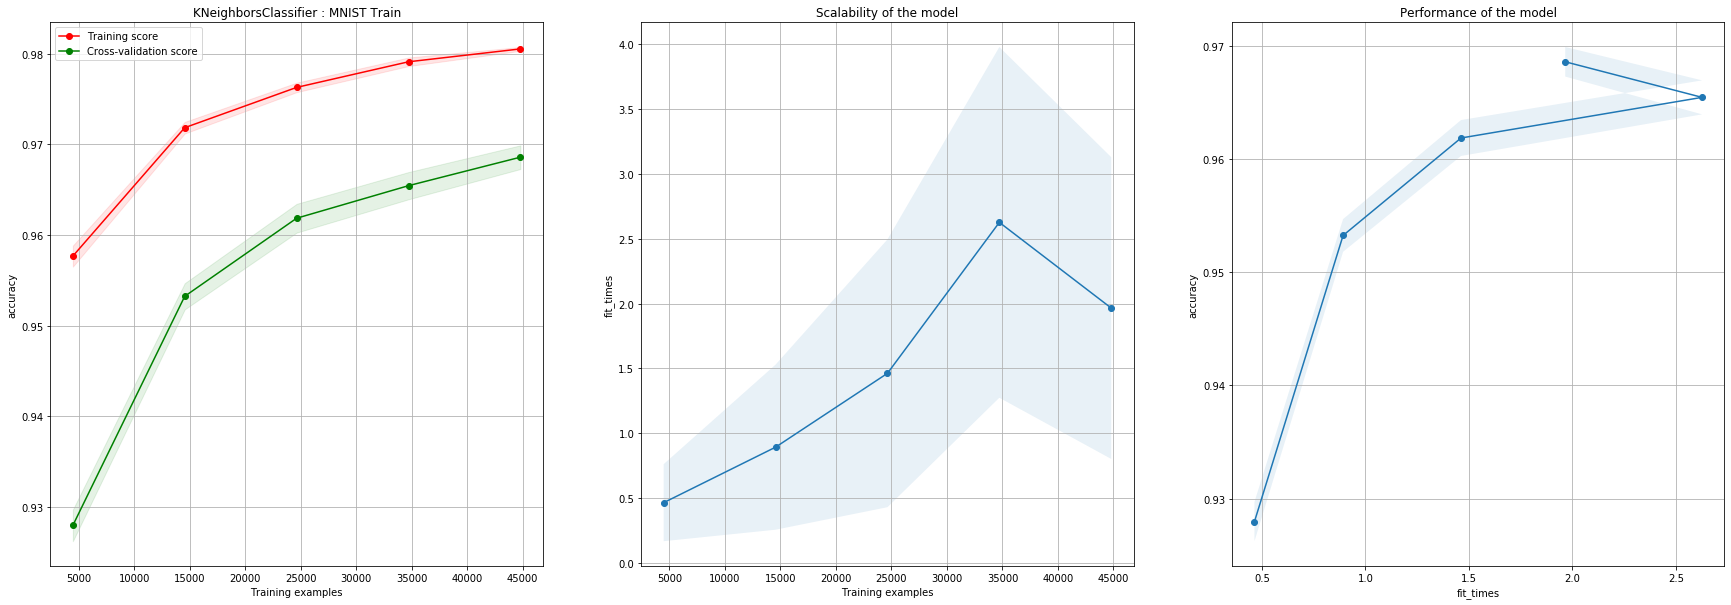

In [49]:
n_neighbors = 4
n_jobs = -1
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(mknn, mnist)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


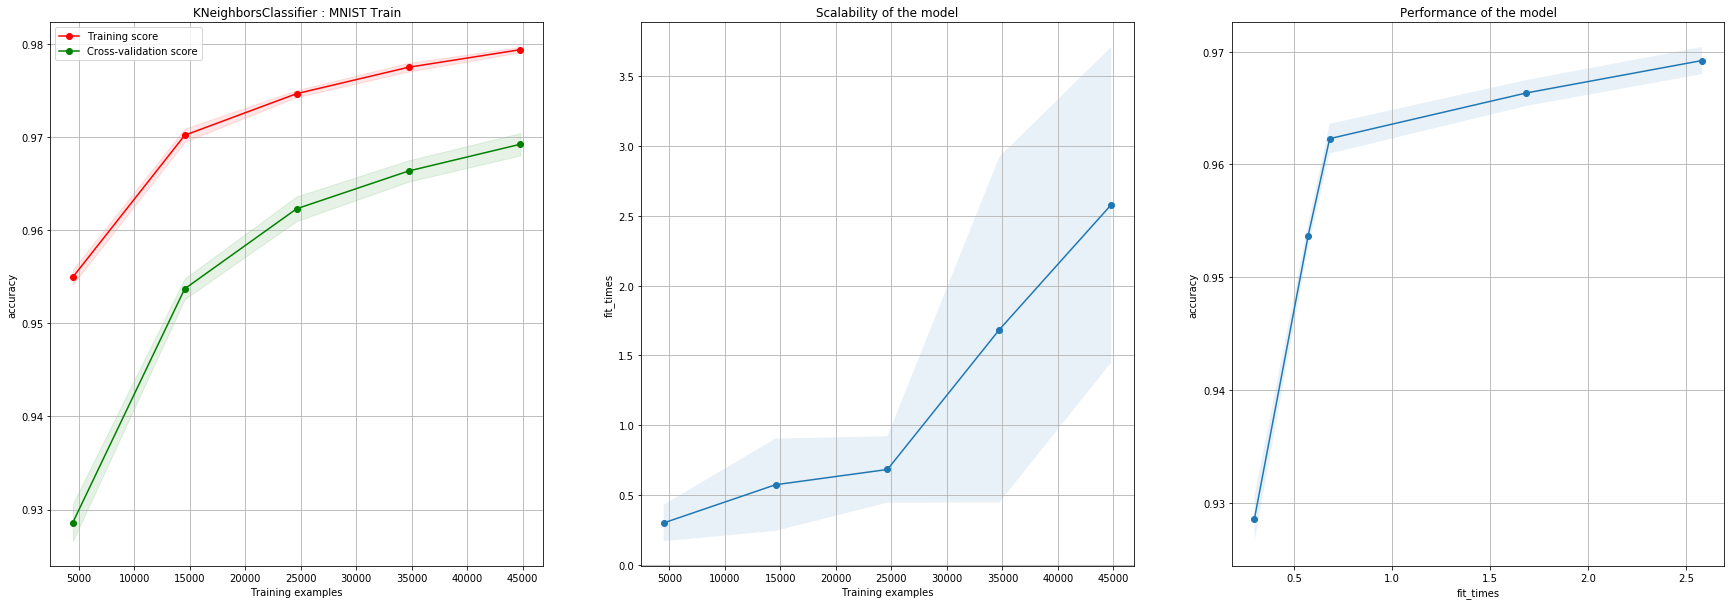

In [51]:
n_neighbors = 5
n_jobs = -1
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_learning_curve(mknn, mnist)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='distance')


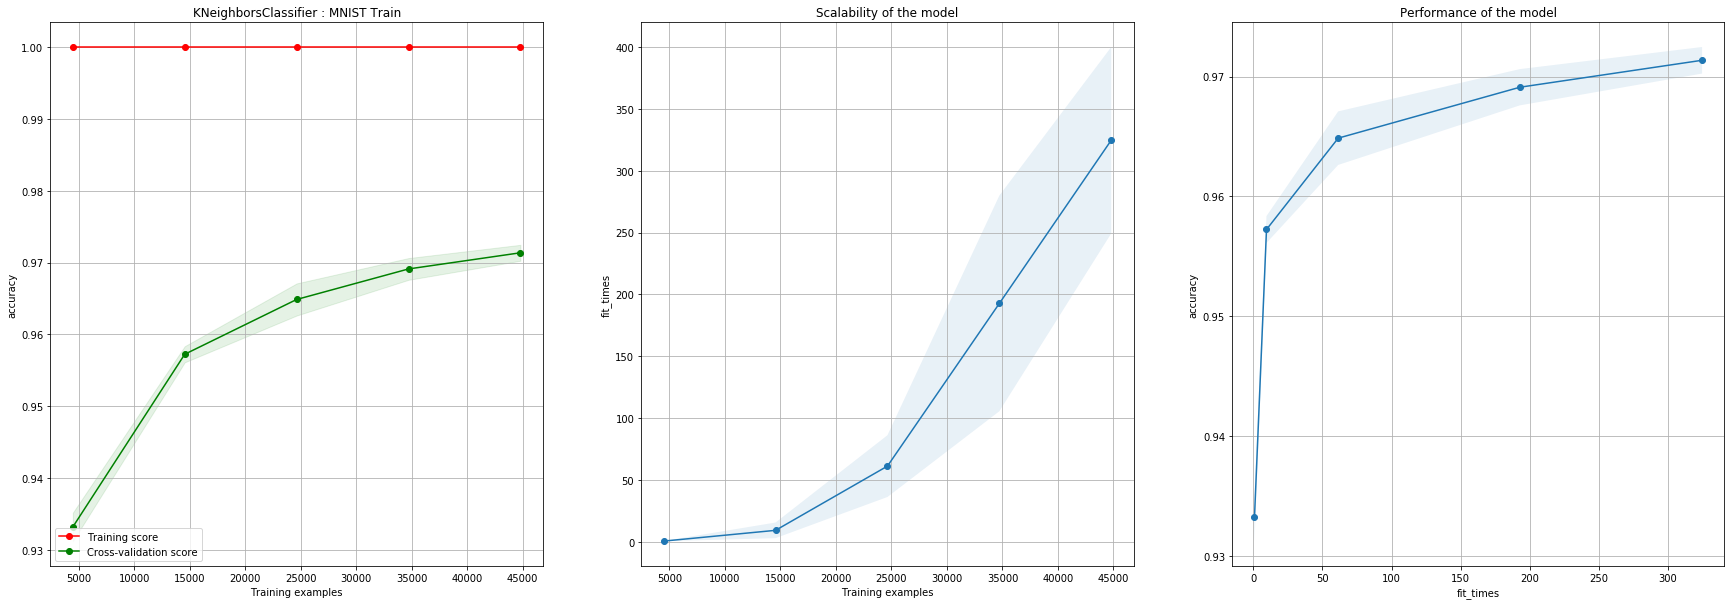

In [93]:
n_neighbors = 3
n_jobs = -1
weights = "distance"
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            weights=weights,
                            n_jobs=n_jobs)
build_learning_curve(mknn, mnist)

## Model Complexity Analysis

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


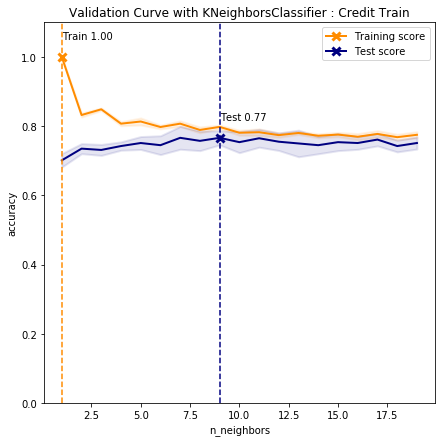

In [103]:
n_neighbors = 12
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_validation_curve(cknn, cred, param_name="n_neighbors", param_range=range(1,20))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


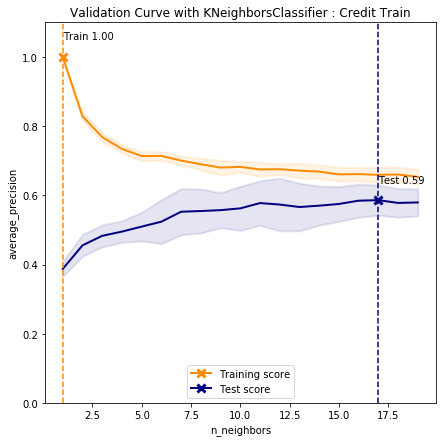

In [102]:
n_neighbors = 12
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_validation_curve(cknn, cred, param_name="n_neighbors", param_range=range(1,20), scoring="average_precision")

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')


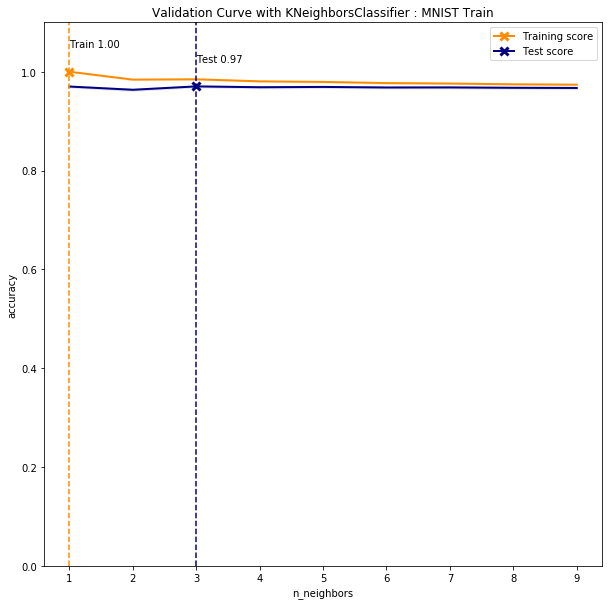

In [14]:
n_neighbors = 3
n_jobs = -1
weights = "uniform"
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            algorithm=algorithm,
                            n_jobs=n_jobs)
build_validation_curve(mknn, mnist, param_name="n_neighbors", param_range=range(1,10))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='distance')


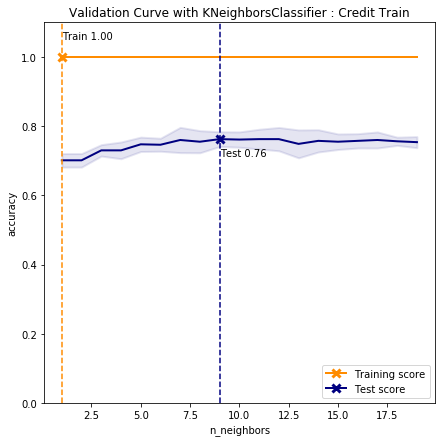

In [109]:
n_neighbors = 12
n_jobs = -1
weights = "distance"
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            weights=weights,
                            n_jobs=n_jobs)
build_validation_curve(cknn, cred, param_name="n_neighbors", param_range=range(1,20))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='distance')


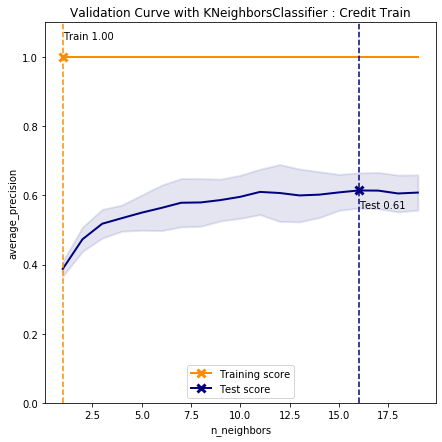

In [110]:
n_neighbors = 12
n_jobs = -1
weights = "distance"
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            weights=weights,
                            n_jobs=n_jobs)
build_validation_curve(cknn, cred, param_name="n_neighbors", param_range=range(1,20), scoring="average_precision")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='distance')


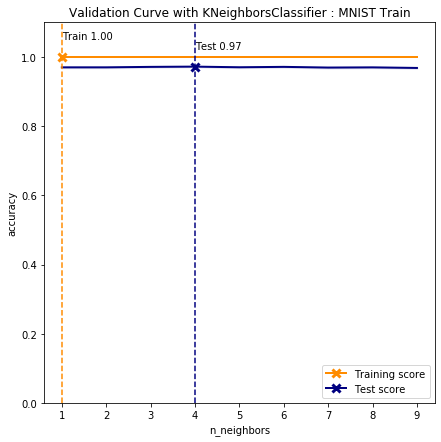

In [90]:
n_neighbors = 3
n_jobs = -1
weights = "distance"
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            weights=weights,
                            n_jobs=n_jobs)
build_validation_curve(mknn, mnist, param_name="n_neighbors", param_range=range(1,10))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


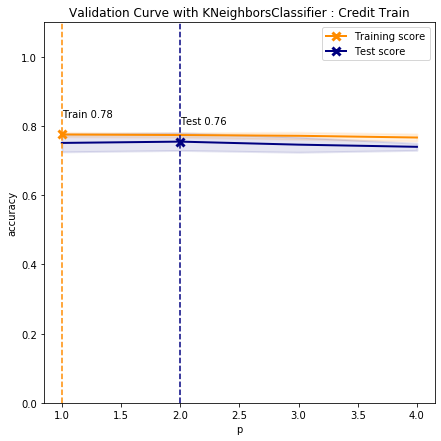

In [104]:
n_neighbors = 12
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_validation_curve(cknn, cred, param_name="p", param_range=range(1,5))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


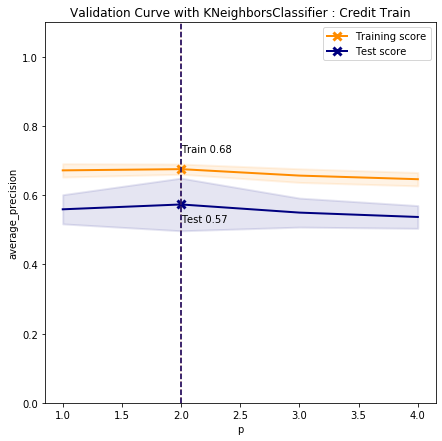

In [107]:
n_neighbors = 12
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_validation_curve(cknn, cred, param_name="p", param_range=range(1,5), scoring="average_precision")

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')


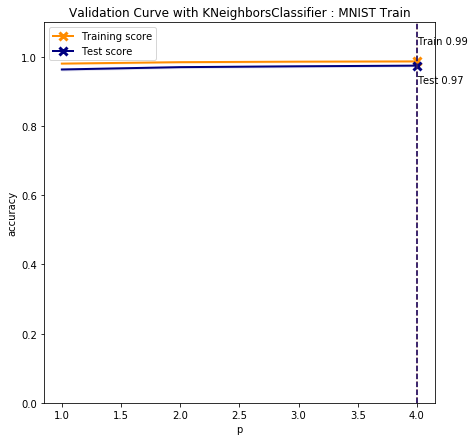

In [108]:
n_neighbors = 3
n_jobs = -1
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
build_validation_curve(mknn, mnist, param_name="p", param_range=range(1,5))

### Grid Search

In [52]:
# No exploratory grid search performed

## Fit

In [74]:
n_neighbors = 12
n_jobs = -1
cknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
cknn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')

In [113]:
n_neighbors = 3
n_jobs = -1
mknn = KNeighborsClassifier(n_neighbors=n_neighbors,
                            n_jobs=n_jobs)
mknn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [81]:
# Fit Credit
X_c, y_c, _ = get_data(cred)
cknn = cknn.fit(X_c, y_c.values.ravel())

In [114]:
# Fit MNIST
X_m, y_m, _ = get_data(mnist)
mknn = mknn.fit(X_m, y_m.values.ravel())

## Final Performance Analysis on TRAINING Set

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


/home/nikola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


/home/nikola/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform'):

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       700
           1       0.30      1.00      0.46       300

    accuracy                           0.30      1000
   macro avg       0.15      0.50      0.23      1000
weighted avg       0.09      0.30      0.14      1000


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


KNeighborsClassifier : Credit Train
Scores:  [0.76875 0.74375 0.7625  0.7875  0.7125 ] Avg:  0.7550000000000001


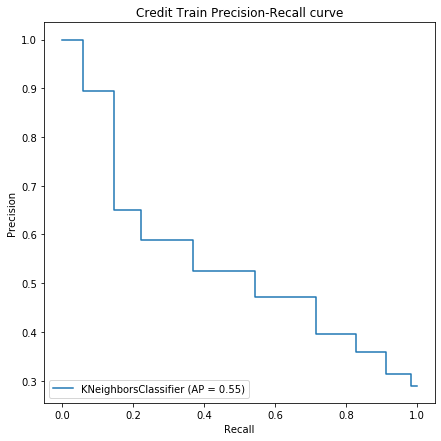

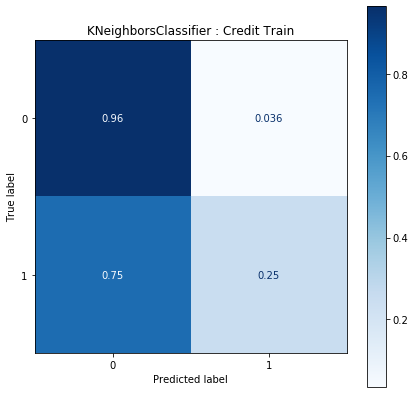

In [82]:
build_cred_precision_recall_curve(cknn, cred)
build_confusion_matrix(cknn, cred)
predicted_cred = cknn.predict(X_cred)
print("Classification report for classifier %s:\n\n%s\n" % (cknn, classification_report(y_cred.values.ravel(), predicted_cred)))
print_cross_val(cknn, cred)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')
Classification report for classifier KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform'):

              precision    recall  f1-score   support

           0       0.56      0.99      0.72      6903
           1       0.99      0.93      0.96      7877
           2       0.90      0.88      0.89      6990
           3       0.84      0.82      0.83      7141
           4       0.95      0.69      0.80      6824
           5       0.98      0.58      0.73      6313
           6       0.95      0.92      0.94      6876
           7       0.92      0.77      0.84      7293
           8       0.60      0.90      0.72      6825
           9       0.87      0.64      0.74     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


KNeighborsClassifier : MNIST Train
Scores:  [0.97035714 0.97089286 0.97098214 0.97098214 0.96830357] Avg:  0.9703035714285715


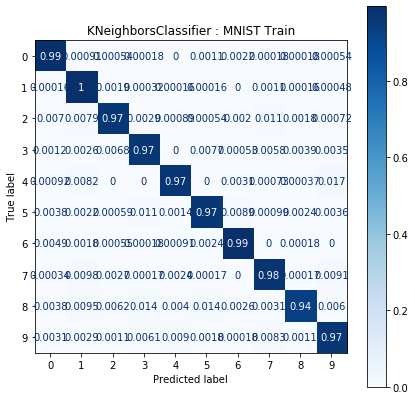

In [89]:
build_confusion_matrix(mknn, mnist)
predicted_mnist = mknn.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (mknn, classification_report(y_mnist.values.ravel(), predicted_mnist)))
print_cross_val(mknn, mnist)

In [ ]:
build_confusion_matrix(mknn, mnist)
predicted_mnist = mknn.predict(X_mnist)
print("Classification report for classifier %s:\n\n%s\n" % (mknn, classification_report(y_mnist.values.ravel(), predicted_mnist)))
print_cross_val(mknn, mnist)

## Final Performance Analysis on TEST Set

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


/home/nikola/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')
Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform'):

              precision    recall  f1-score   support

           0       0.76      0.97      0.86       140
           1       0.82      0.30      0.44        60

    accuracy                           0.77       200
   macro avg       0.79      0.64      0.65       200
weighted avg       0.78      0.77      0.73       200


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                     weights='uniform')


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


KNeighborsClassifier : Credit Test
Scores:  [0.75  0.65  0.75  0.725 0.75 ] Avg:  0.725


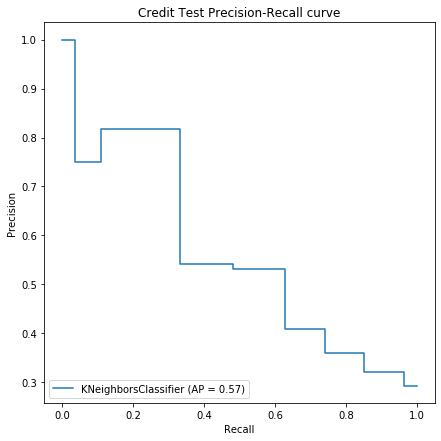

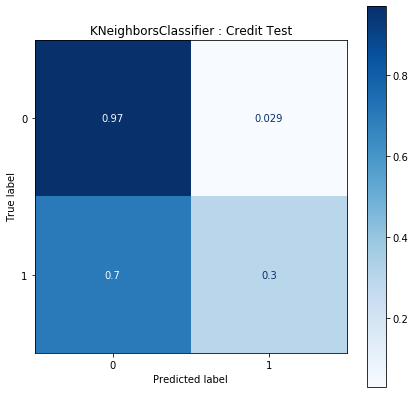

In [79]:
build_cred_precision_recall_curve(cknn, cred_test)
build_confusion_matrix(cknn, cred_test)
predicted_cred = cknn.predict(X_cred_test)
print("Classification report for classifier %s:\n\n%s\n" % (cknn, classification_report(y_cred_test.values.ravel(), predicted_cred)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')
Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform'):

              precision    recall  f1-score   support

           0      0.974     0.994     0.984      1381
           1      0.961     0.997     0.978      1575
           2      0.978     0.968     0.973      1398
           3      0.964     0.968     0.966      1428
           4      0.978     0.966     0.972      1365
           5      0.968     0.955     0.961      1263
           6      0.980     0.992     0.986      1375
           7      0.976     0.971     0.974      1459
           8      0.990     0.935     0.962      1365
           9      0.953     0.967     0.960      1

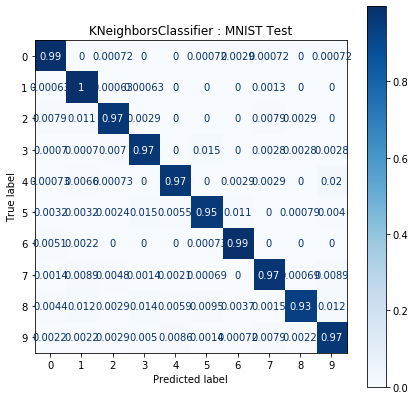

In [115]:
build_confusion_matrix(mknn, mnist_test)
predicted_mnist = mknn.predict(X_mnist_test)
print("Classification report for classifier %s:\n\n%s\n" % (mknn, classification_report(y_mnist_test.values.ravel(), predicted_mnist, digits=3)))